# **Resolvendo o ambiente de táxi com Q-Learning**
- Link do Tutorial: https://towardsdatascience.com/solving-the-taxi-environment-with-q-learning-a-tutorial-c76c22fc5d8f

### Instalações necessárias 

In [1]:
# !pip install cmake
# !pip install gym[atari]
# !pip install scipy 
# !pip install pygame

### Bibliotecas

In [2]:
# Libs
import gym
import numpy as np
import matplotlib.pyplot as plt
import random
from IPython.display import clear_output
from time import sleep
from matplotlib import animation

### Criando e renderizando um ambiente Taxi-v3

espaço de estado: Discrete(500)
Espaço de ação: Discrete(6)
Estado: 473
Ação: 2
máscara de ação: [0 1 1 0 1 0]
Recompensa: -1


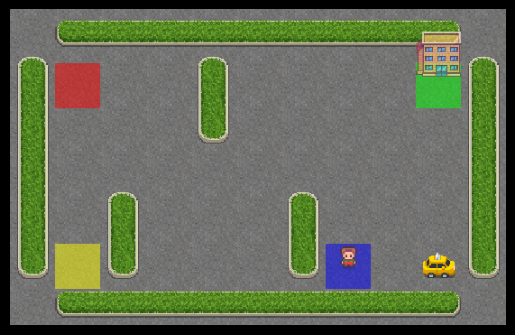

In [3]:
# Inicializar e validano o ambiente
env = gym.make("Taxi-v3", render_mode="rgb_array").env
state, _ = env.reset()

# Dimensões de impressão do estado e do espaço de ação
print(f'espaço de estado: {env.observation_space}')
print(f'Espaço de ação: {env.action_space}')

# Exemplo de ação aleatória
action = env.action_space.sample(env.action_mask(state))
next_state, reward, done, _, _ = env.step(action)

# saída de impressão
print(f'Estado: {state}')
print(f'Ação: {action}')
print(f'máscara de ação: {env.action_mask(state)}')
print(f'Recompensa: {reward}')

# Renderizar e plotar um quadro de ambiente
frame = env.render()
plt.imshow(frame)
plt.axis("off")
plt.show();

### Funções para criar e salva a animação

In [4]:
# Função para rodar a animação
def roda_animaca(experience_buffer):
    time_lag = 0.05  # Atraso (em s) entre quadros
    for experience in experience_buffer:
        # Plotar quadro
        clear_output(wait=True)
        plt.imshow(experience['frame'])
        plt.axis('off')
        plt.show()

        # Saída de impressão
        print(f"Episódio: {experience['episode']}/{experience_buffer[-1]['episode']}")
        print(f"Epoch: {experience['epoch']}/{experience_buffer[-1]['epoch']}")
        print(f"Estado: {experience['state']}")
        print(f"Ação: {experience['action']}")
        print(f"Recompensa: {experience['reward']}")
        # Pausar animação
        sleep(time_lag)

In [5]:
# Função para criar e para armazenar GIFs
def armazenarGif(experience_buffer, path='./', filename='animation.gif'):
    fps = 5   # Definir frame por segundo
    dpi = 300  # Definir pontos por polegada
    interval = 50  # Intervalo entre quadros (em ms)

    # Recupere quadros do buffer de experiência
    frames = []
    for experience in experience_buffer:
        frames.append(experience['frame'])

    # Corrigir tamanho do quadro
    plt.figure(figsize=(frames[0].shape[1] / dpi, frames[0].shape[0] / dpi), dpi=dpi)
    patch = plt.imshow(frames[0])
    plt.axis('off')

    # Gerar animação
    def animate(i):
        patch.set_data(frames[i])

    anim = animation.FuncAnimation(plt.gcf(), animate, frames=len(frames), interval=interval)

    # Salvar saída como gif
    anim.save(path + filename, writer='imagemagick', fps=fps)

### Testando um agente aleatório

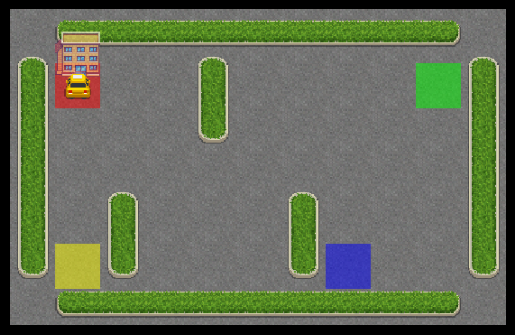

Episódio: 1/1
Epoch: 1636/1636
Estado: 0
Ação: 5
Recompensa: -6251
# epochs: 1637
# Desistências falhadas:: 515


In [6]:
# Simulação com agente aleatório
epoch = 0
num_failed_dropoffs = 0
experience_buffer = []
acum_reward = 0

done = False

state, _ = env.reset()

while not done:
    # Exemplo de ação aleatória
    # Seleção de ação sem máscara de ação
    action = env.action_space.sample()

    # Seleção de ação com máscara de ação"
    #action = env.action_space.sample(env.action_mask(state))

    state, reward, done, _, _ = env.step(action)
    acum_reward += reward

    # Armazena a experiência no dicionário
    experience_buffer.append({
        "frame": env.render(),
        "episode": 1,
        "epoch": epoch,
        "state": state,
        "action": action,
        "reward": acum_reward,
        }
    )

    if reward == -10:
        num_failed_dropoffs += 1

    epoch += 1

# Execute a animação e imprima a saída do console
roda_animaca(experience_buffer)

print(f'# epochs: {epoch}')
print(f'# Desistências falhadas:: {num_failed_dropoffs}')

### Treinando o agente

Episódio #: 10000


===Treinamento concluído.===



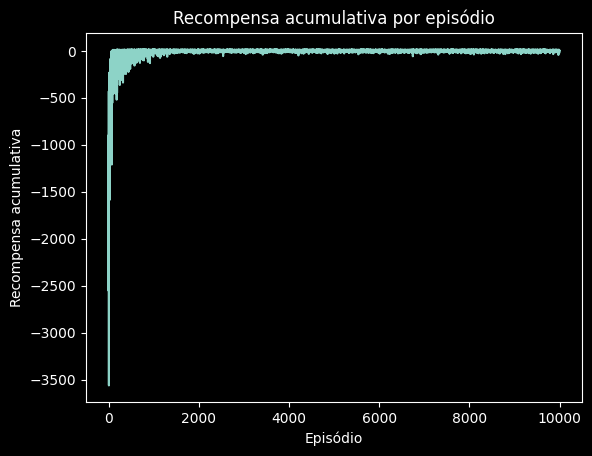

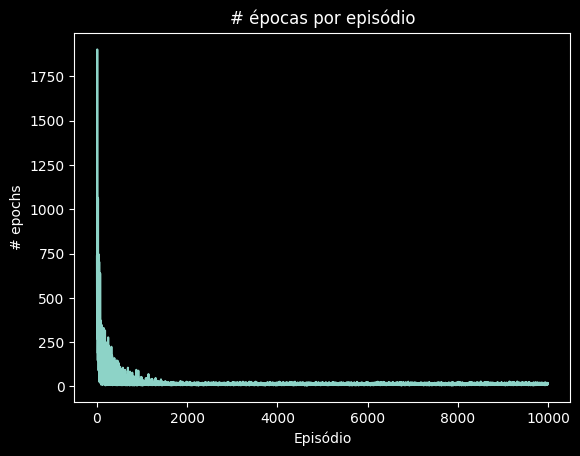

In [7]:
# Treinando o agente
q_table = np.zeros([env.observation_space.n, env.action_space.n])

# Hiperparâmetros
alpha = 0.1  # Taxa de Aprendizagem
gamma = 1.0  # Taxa de desconto
epsilon = 0.1  # Taxa de exploração
num_episodes = 10000  # Número de episódios

# Saída para gráficos
acum_rewards = np.zeros([num_episodes])
total_epochs = np.zeros([num_episodes])

for episode in range(1, num_episodes+1):
    # Redefinir ambiente
    state, info = env.reset()
    epoch = 0 
    num_failed_dropoffs = 0
    done = False
    acum_reward = 0

    while not done:
        
        if random.uniform(0, 1) < epsilon:
            # Exploração básica [~0,47m]
            action = env.action_space.sample() # Exemplo de ação aleatória (exploração)
            
            # Exploração com máscara de ação [~1,52m]
            # action = env.action_space.sample(env.action_mask(state)) "Exploração com máscara de ação"
        else:      
            # Exploração com máscara de ação [~1m52s]
            # action_mask = np.where(info["action_mask"]==1,0,1) # inverter
            # masked_q_values ​​= np.ma.array(q_table[state], mask=action_mask, dtype=np.float32)
            # action = np.ma.argmax(masked_q_values, axis=0)

            # Exploração com desempate aleatório [~1m19s]
            # action = np.random.choice(np.flatnonzero(q_table[state] == q_table[state].max()))
            
            # Exploração básica [~47s]
            action = np.argmax(q_table[state]) # Selecione a ação mais conhecida (exploração)

        next_state, reward, done, _ , info = env.step(action) 

        acum_reward += reward

        old_q_value = q_table[state, action]
        next_max = np.max(q_table[next_state])

        new_q_value = (1 - alpha) * old_q_value + alpha * (reward + gamma * next_max)
        
        q_table[state, action] = new_q_value

        if reward == -10:
            num_failed_dropoffs += 1

        state = next_state
        epoch += 1

        total_epochs[episode-1] = epoch
        acum_rewards[episode-1] = acum_reward

    if episode % 100 == 0:
        clear_output(wait=True)
        print(f"Episódio #: {episode}")

print("\n")
print("===Treinamento concluído.===\n")

# Plotar convergência de recompensa
plt.title("Recompensa acumulativa por episódio")
plt.xlabel("Episódio")
plt.ylabel("Recompensa acumulativa")
plt.plot(acum_rewards)
plt.show()

# Convergência da época do gráfico
plt.title("# épocas por episódio")
plt.xlabel("Episódio")
plt.ylabel("# epochs")
plt.plot(total_epochs)
plt.show()

### Teste de Performance 

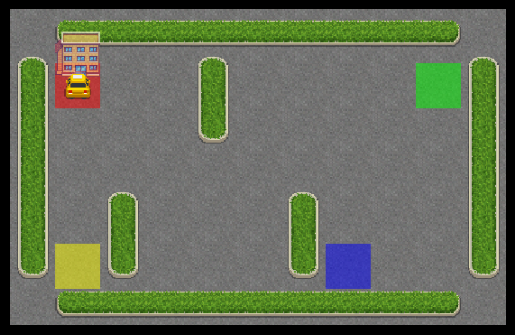

Episódio: 1/1
Epoch: 14/14
Estado: 0
Ação: 5
Recompensa: 7


Resultados do teste após 1 episódios:
Média de # épocas por episódio: 15.0
Número médio de desistências com falha por episódio: 0.0


In [8]:
# Testando o desempenho da Performance após o treinamento

num_epochs = 0
total_failed_deliveries = 0
num_episodes = 1
experience_buffer = []
store_gif = True

for episode in range(1, num_episodes+1):
    # Inicializar buffer de experiência

    my_env = env.reset()
    state = my_env[0]
    epoch = 1 
    num_failed_deliveries =0
    cum_reward = 0
    done = False

    while not done:
        action = np.argmax(q_table[state])
        state, reward, done, _, _ = env.step(action)
        cum_reward += reward

        if reward == -10:
            num_failed_deliveries += 1

        # Armazena quadro renderizado no dicionário de animação
        experience_buffer.append({
            'frame': env.render(),
            'episode': episode,
            'epoch': epoch,
            'state': state,
            'action': action,
            'reward': cum_reward
            }
        )

        epoch += 1

    total_failed_deliveries += num_failed_deliveries
    num_epochs += epoch

    if store_gif:
        armazenarGif(experience_buffer)

# Execute a animação e imprima a saída
roda_animaca(experience_buffer)

# Print final results
print("\n") 
print(f"Resultados do teste após {num_episodes} episódios:")
print(f"Média de # épocas por episódio: {num_epochs / num_episodes}")
print(f"Número médio de desistências com falha por episódio: {total_failed_deliveries / num_episodes}")